In [7]:
# Install and import TF2
!pip install -q tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
# More imports
from tensorflow.keras.layers import Input,Dense,Embedding,Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# data is from: https://grouplens.org/datasets/movielens
# in case the link changes in the future

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [10]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip


In [11]:
!ls

ml-20m	ml-20m.zip  sample_data


In [12]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
# we cant trust the userId and movieId to be numbered 0...N-1
# lets just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id,axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [0]:
# do the same for moview Ids

# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#   global current_movie_id, custom_movie_map
#   old_movie_id = row['movieId']
#   if old_movie_id not in custom_movie_map:
#     custom_movie_map[old_movie_id] = current_movie_id
#     current_movie_id += 1
#   return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id,axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [0]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [0]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Get embedding dimension
K = 10

In [0]:
# Make a neural network
# User Input
u = Input(shape=(1,))
# Movie input
m = Input(shape=(1,))
# User embedding
u_emb = Embedding(N,K)(u) # output is (num_samples,1,K)
# Movie embedding
m_emb = Embedding(M,K)(m) # output is (num_samples,1,K)
# Flatten both embeddings
u_emb = Flatten()(u_emb) # now its (num_samples, K)
m_emb = Flatten()(m_emb) # now its (num_samples, K)
# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb,m_emb]) # now its (num_samples, 2K)
# Now that we have a feature vector, its just a regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
x = Dense(1)(x)

In [0]:
# Build the model and compile
model = Model(inputs=[u,m],outputs=x)
model.compile(
    loss='mse',
    optimizer=SGD(lr=0.08,momentum=0.9),
)

In [0]:
# split the data
user_ids,movie_ids,ratings = shuffle(user_ids,movie_ids,ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [21]:
r = model.fit(
    x=[train_user,train_movie],
    y=train_ratings,
    epochs=25,
    batch_size=1024,
    verbose=2, #goes faster when you dont print the progrss bar
    validation_data=([test_user,test_movie], test_ratings),
)

Train on 16000210 samples, validate on 4000053 samples
Epoch 1/25
16000210/16000210 - 237s - loss: 0.7806 - val_loss: 0.7241
Epoch 2/25
16000210/16000210 - 241s - loss: 0.7028 - val_loss: 0.7012
Epoch 3/25
16000210/16000210 - 238s - loss: 0.6793 - val_loss: 0.6826
Epoch 4/25
16000210/16000210 - 241s - loss: 0.6635 - val_loss: 0.6760
Epoch 5/25
16000210/16000210 - 233s - loss: 0.6534 - val_loss: 0.6737
Epoch 6/25
16000210/16000210 - 233s - loss: 0.6418 - val_loss: 0.6586
Epoch 7/25
16000210/16000210 - 232s - loss: 0.6242 - val_loss: 0.6504
Epoch 8/25
16000210/16000210 - 240s - loss: 0.6103 - val_loss: 0.6421
Epoch 9/25
16000210/16000210 - 241s - loss: 0.6008 - val_loss: 0.6404
Epoch 10/25
16000210/16000210 - 232s - loss: 0.5927 - val_loss: 0.6405
Epoch 11/25
16000210/16000210 - 238s - loss: 0.5848 - val_loss: 0.6335
Epoch 12/25
16000210/16000210 - 235s - loss: 0.5765 - val_loss: 0.6326
Epoch 13/25
16000210/16000210 - 235s - loss: 0.5684 - val_loss: 0.6306
Epoch 14/25
16000210/16000210 -

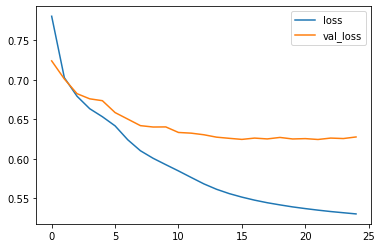

In [22]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [0]:
# is this on par with other approaches?
# https://datascience.stackexchange.com/questions/29740/benchmark-result-for-movielen
np.sqrt(0.6259)